## TODO
1. fill "null" in condition based on the manufacturing year
2. How should we handle states? 
3. What metrics do we want to calculate model performance? (r2 score, accuracy)

In [60]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_df_with_manufact.csv', keep_default_na=False)

In [3]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,13995,2012.0,ford,f-150,good,6 cylinders,gas,188406.0,automatic,4wd,truck,grey,mn
1,7995,2010.0,chevrolet,equinox,good,4 cylinders,gas,108124.0,automatic,4wd,SUV,grey,mn
2,8995,2011.0,chevrolet,traverse,good,6 cylinders,gas,178054.0,automatic,4wd,SUV,white,mn
3,10995,2014.0,ford,explorer,good,6 cylinders,gas,170259.0,automatic,4wd,SUV,white,mn
4,12995,2004.0,ram,2500,good,6 cylinders,diesel,309621.0,automatic,4wd,truck,custom,mn


In [4]:
for col in df.columns:
    print(col, "--", len(df[df[col]=="null"]), "--", len(df[col].unique()))

print("total samples: ", len(df))

price -- 0 -- 7850
year -- 0 -- 41
manufacturer -- 900 -- 37
model -- 0 -- 1520
condition -- 25416 -- 7
cylinders -- 13387 -- 9
fuel -- 0 -- 5
odometer -- 0 -- 45314
transmission -- 0 -- 3
drive -- 0 -- 3
type -- 0 -- 13
paint_color -- 0 -- 12
state -- 0 -- 51
total samples:  83003


# Convert categorical features
------

In [5]:
# add all the columns you want to dummy/one hot
onehot_these_columns = []
delete_these_columns = []

## Model

In [6]:
len(df['model'].unique())
delete_these_columns.append('model')

## Manufacturer

In [7]:
df['manufacturer'].unique()

array(['ford', 'chevrolet', 'ram', 'buick', 'nissan', 'hyundai', 'dodge',
       'subaru', 'toyota', 'lexus', 'volvo', 'chrysler', 'jeep', 'acura',
       'gmc', 'kia', 'honda', 'volkswagen', 'bmw', 'null', 'pontiac',
       'cadillac', 'mazda', 'lincoln', 'saturn', 'fiat', 'audi',
       'mercury', 'mercedes-benz', 'mini', 'mitsubishi', 'jaguar',
       'infiniti', 'rover', 'tesla', 'land rover', 'alfa-romeo'],
      dtype=object)

In [8]:
price_buckets = {}
for k,v in dict(df.groupby("manufacturer")['price'].mean()).items():
    price_buckets[k] = int(v/5000)
print(price_buckets)

{'acura': 2, 'alfa-romeo': 5, 'audi': 2, 'bmw': 2, 'buick': 2, 'cadillac': 2, 'chevrolet': 2, 'chrysler': 1, 'dodge': 2, 'fiat': 1, 'ford': 3, 'gmc': 3, 'honda': 2, 'hyundai': 2, 'infiniti': 2, 'jaguar': 2, 'jeep': 3, 'kia': 2, 'land rover': 2, 'lexus': 2, 'lincoln': 2, 'mazda': 1, 'mercedes-benz': 3, 'mercury': 0, 'mini': 1, 'mitsubishi': 1, 'nissan': 2, 'null': 3, 'pontiac': 1, 'ram': 4, 'rover': 3, 'saturn': 0, 'subaru': 2, 'tesla': 7, 'toyota': 2, 'volkswagen': 2, 'volvo': 1}


In [9]:
# onehot_these_columns.append("manufacturer")
df['manufacturer'].replace(price_buckets, inplace=True)

In [10]:
df['manufacturer'].unique()

array([3, 2, 4, 1, 0, 7, 5])

## Condition

In [11]:
df['condition'].unique()

array(['good', 'fair', 'excellent', 'like new', 'null', 'new', 'salvage'],
      dtype=object)

In [12]:
df.groupby("condition")['price'].mean()

condition
excellent    12296.954851
fair          3464.130298
good         11390.026245
like new     15323.040108
new          16837.903030
null         17161.635623
salvage       5569.265306
Name: price, dtype: float64

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'manufacturer'}>,
        <AxesSubplot:title={'center':'odometer'}>]], dtype=object)

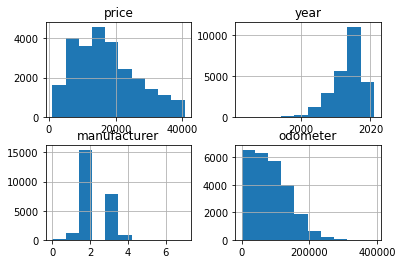

In [13]:
df[df['condition']=="null"].hist(bins=10)

In [14]:
onehot_these_columns.append("condition")

## Cylinders

In [15]:
df.groupby("cylinders")['price'].mean()

cylinders
10 cylinders    14549.672986
12 cylinders    10851.625000
3 cylinders     11303.132812
4 cylinders     10910.030387
5 cylinders      6950.400327
6 cylinders     13270.627364
8 cylinders     16473.431071
null            16542.824457
other           13574.572650
Name: price, dtype: float64

We have seen previously that most of the cylinders are either 4,6,8 or "null". Looking only at these categories, it seems that the trend is more the cylinders, higher the cost. So it might make sense to convert these categories to numbers instead of one-hot. There are very few cars with ['other',10,12,3,5] cyliners. We can convert the numbered categories to corresponding numbers and treat others as null.



**Other** *assign it the mean of all values* <br>
**null** *assign it the mean of all values*

<AxesSubplot:>

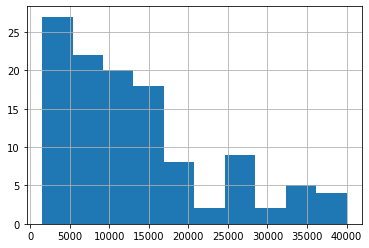

In [16]:
df[df['cylinders']=="other"]['price'].hist(bins=10)

In [17]:
mean_cylinder = (4+6+8)/3

replace_cylinders = {'3 cylinders':3, '4 cylinders':4, '5 cylinders':5, 
           '6 cylinders':6, '8 cylinders':8, '10 cylinders':10, 
           '12 cylinders':12, 'null':mean_cylinder, 'other':mean_cylinder}

df['cylinders'].replace(replace_cylinders, inplace=True)

In [18]:
df['cylinders'].unique()

array([ 6.,  4.,  8.,  5.,  3., 10., 12.])

## Fuel

In [19]:
df.groupby("fuel")['price'].agg(Mean='mean', Count='count')

,Mean,Count
fuel,,
diesel,20854.858158,3941
electric,15166.683908,174
gas,13025.972290,75784
hybrid,11242.358569,1202
other,19159.013670,1902


Since there are only 5 categories, we can convert this column to dummy (onehot).

In [20]:
onehot_these_columns.append('fuel')

## Transmission

In [21]:
df.groupby("transmission")['price'].agg(Mean='mean', Count='count')

,Mean,Count
transmission,,
automatic,13406.896059,74927
manual,10966.174769,4875
other,19976.082162,3201


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [22]:
onehot_these_columns.append('transmission')

## Drive

In [23]:
df.groupby("drive")['price'].agg(Mean='mean', Count='count')

,Mean,Count
drive,,
4wd,16590.406614,31841
fwd,10372.548913,38037
rwd,15173.048533,13125


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [24]:
onehot_these_columns.append('drive')

## Type

In [25]:
df.groupby("type")['price'].agg(Mean='mean', Count='count')

,Mean,Count
type,,
SUV,13817.498382,23799
bus,18051.030303,33
convertible,12887.358553,1520
coupe,15030.873151,3989
hatchback,8957.641141,3330
mini-van,9352.472274,2164
offroad,14647.139665,179
other,17443.189781,1644
pickup,20043.934753,7418


Since the price does fluctuate with the type of vehicle, this feature seems useful. Let's convert this to a dummy (onehot) as well.

In [26]:
onehot_these_columns.append('type')

## Paint

In [27]:
df.groupby("paint_color")['price'].agg(Mean='mean', Count='count')

,Mean,Count
paint_color,,
black,14574.167654,15860
blue,11694.343485,8833
brown,10781.580084,1898
custom,14022.346578,3171
green,9246.564463,2133
grey,12753.835218,9376
orange,16363.644211,475
purple,9380.276151,239
red,12791.435066,8139


It looks like some colors are preferred over the others. Let's also convert this column to dummy(onehot).

In [44]:
delete_these_columns.append('paint_color')

## State

In [45]:
# df.groupby("state")['price'].agg(Mean='mean', Count='count')
delete_these_columns.append('state')

## Year

In [46]:
df['year'].describe()

count    83003.000000
mean      2011.128610
std          5.800385
min       1981.000000
25%       2007.000000
50%       2012.000000
75%       2016.000000
max       2021.000000
Name: year, dtype: float64

In [47]:
df['year_count'] = df['year']-1980
delete_these_columns.append('year')

<AxesSubplot:xlabel='year_count'>

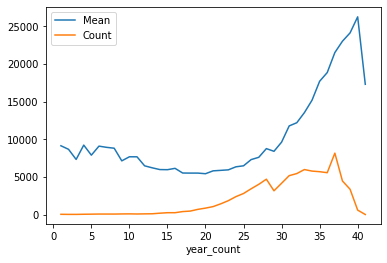

In [48]:
df.groupby('year_count')['price'].agg(Mean='mean', Count='count').plot()

## Convert to onehot/dummy

In [49]:
print("We want to convert these columns into onehot:\n", onehot_these_columns)


We want to convert these columns into onehot:
 ['condition', 'fuel', 'transmission', 'drive', 'type']


In [50]:
df_dummy = pd.get_dummies(df, columns=onehot_these_columns)

## Drop columns

In [51]:
df_dummy.drop(columns=delete_these_columns, axis=1, inplace=True)

In [52]:
df_dummy.head()

,price,manufacturer,cylinders,odometer,year_count,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,13995,3,6.0,188406.0,32.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7995,2,4.0,108124.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8995,2,6.0,178054.0,31.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10995,3,6.0,170259.0,34.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12995,4,6.0,309621.0,24.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
df_dummy.dtypes

price                       int64
manufacturer                int64
cylinders                 float64
odometer                  float64
year_count                float64
condition_excellent         uint8
condition_fair              uint8
condition_good              uint8
condition_like new          uint8
condition_new               uint8
condition_null              uint8
condition_salvage           uint8
fuel_diesel                 uint8
fuel_electric               uint8
fuel_gas                    uint8
fuel_hybrid                 uint8
fuel_other                  uint8
transmission_automatic      uint8
transmission_manual         uint8
transmission_other          uint8
drive_4wd                   uint8
drive_fwd                   uint8
drive_rwd                   uint8
type_SUV                    uint8
type_bus                    uint8
type_convertible            uint8
type_coupe                  uint8
type_hatchback              uint8
type_mini-van               uint8
type_offroad  

-----
# Model
-----

In [54]:
y = df_dummy['price']
X = df_dummy.drop(columns=['price'])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [56]:
len(X_train), len(X_test)

(66402, 16601)

In [57]:
def loss_MSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5


# find whether our prediction is correct within a certain threshold
def accuracy(y_true, y_pred, thresh=100):
    return np.sum(np.where(abs(y_true-y_pred)<thresh, 1, 0)) / len(y_true)
    

In [65]:
threshold = 2000

### Linear Regression

In [66]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [67]:
y_pred = model.predict(X_test)
print("Loss MSE: ", loss_MSE(y_test, y_pred))
print("Accuracy with threshold ", thresh, ":", accuracy(y_test,y_pred, threshold))

Loss MSE:  4755.211238683027
Accuracy with threshold  1000 : 0.3769652430576471


### Random Forest

In [68]:
model = RandomForestClassifier(max_depth=5, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [69]:
y_pred = model.predict(X_test)
print("Loss MSE: ", loss_MSE(y_test, y_pred))
print("Accuracy with threshold ", thresh, ":", accuracy(y_test,y_pred, threshold))

Loss MSE:  6548.340464631668
Accuracy with threshold  1000 : 0.3792542617914583
